In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files

In [ ]:
def sum_of_squares(samples: np.ndarray) -> float:
    return ((samples - samples.mean()) ** 2).sum()

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving MoviesOnStreamingPlatforms_updated.csv to MoviesOnStreamingPlatforms_updated.csv
User uploaded file "MoviesOnStreamingPlatforms_updated.csv" with length 1942970 bytes


In [ ]:
df = pd.read_csv('MoviesOnStreamingPlatforms_updated.csv')
df.head(2)

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0


# Анализ

Обратим внимание на ряд числовых показателей:

*   `year` - год выпуска
*   `IMDb` - рейтинг на самом большо агрегаторе фильмов
*   `Runtime` - продолжительность фильмов

Средний рейтинг фильмов на `IMDb` - $5.9$, что достаточно близко к значению 50% квантиля, представляющего собой медиану выборки. Отдельно стоит проверить выборку рейтингов на нормальность.

Средняя продолжительность фильмов $93.4$ минуты, что также близко к медиане. Это значение совпадает и с теоретическим - $90$ минут это минимальное время, которое необходимо для просмотра фильмов в кино. Также интересно проверить длительность на нормальность. 

А вот среднее и медиана (50% квантиль) года выпуска не совпадают достаточно заметно. Это скорее всего связано с тем, что поток фильмов год к году в целом расёт, тогда как первые фильмы выпускались очень давно и тянут "среднее" вниз. Это требует отдельного исследования. 



In [ ]:
df.describe()

,Unnamed: 0,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Type,Runtime
count,16744.000000,16744.000000,16744.000000,16173.000000,16744.000000,16744.000000,16744.000000,16744.000000,16744.0,16152.000000
mean,8371.500000,8372.500000,2003.014035,5.902751,0.212613,0.053930,0.737817,0.033684,0.0,93.413447
std,4833.720789,4833.720789,20.674321,1.347867,0.409169,0.225886,0.439835,0.180419,0.0,28.219222
min,0.000000,1.000000,1902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,4185.750000,4186.750000,2000.000000,5.100000,0.000000,0.000000,0.000000,0.000000,0.0,82.000000
50%,8371.500000,8372.500000,2012.000000,6.100000,0.000000,0.000000,1.000000,0.000000,0.0,92.000000
75%,12557.250000,12558.250000,2016.000000,6.900000,0.000000,0.000000,1.000000,0.000000,0.0,104.000000
max,16743.000000,16744.000000,2020.000000,9.300000,1.000000,1.000000,1.000000,1.000000,0.0,1256.000000


Необходимо убрать пропуски в данных для корректной обработки в дальнейшем. Пропуски заменяются на медианные значения.

In [ ]:
df['Runtime'] = df['Runtime'].fillna(df['Runtime'].median())

In [ ]:
df['IMDb'] = df['IMDb'].fillna(df['IMDb'].median())

Удалим из данных фильмы длительностю более 500 минут

In [ ]:
index_list = df[df['Runtime'] > 500].index
df = df.drop(index_list)

## Проверка рейтинга на нормальное распределение

### Визуальный анализ (гистограммы)

Построим гистограммы интеерсующих нас признаков, а также наложим поверх гистограм то, как бы выглядело нормальное распределение с параметрами, рассчитанными на основе выборок.

Мы можем видеть, что серьёзные выводы можно соделать только относительно распределения параметра `year` - оно распределено точно не нормально. 



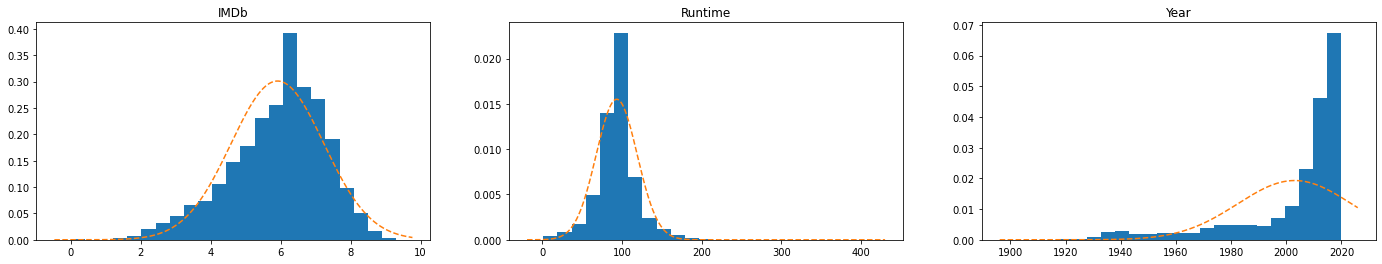

In [ ]:
keys = ['IMDb', 'Runtime', 'Year']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=23)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

### Визуальный анализ (квантили)

Построим Q-Q кривую. Это график, который показывает соответствие между теоретическим значением квантиля на выборке и его реальным значением. 

Чем ближке график к графику $y=x$, тем более нормальным является распределение значений выборки. 

Как мы и говорили ранее `year` не является распределённым нормально. Тогда как `runtime`, `IMDb` распределён относительно нормально.

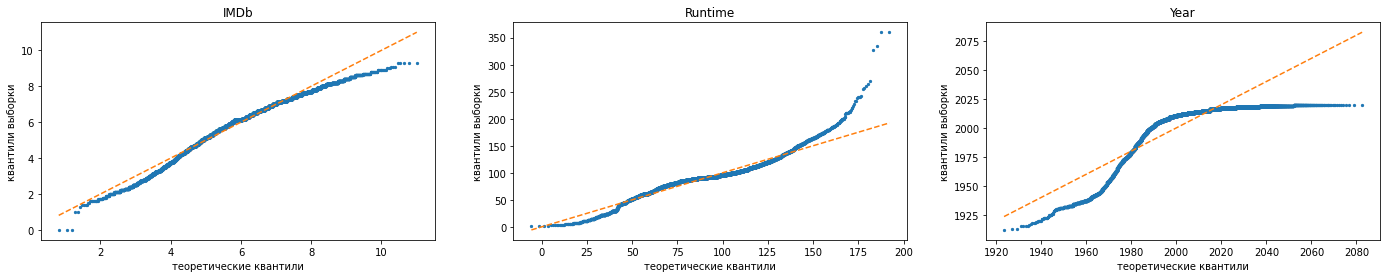

In [ ]:
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

### Стастические показатели для выборок

Оценим нормальность выборок также  на основании известных характеристик нормального распределения. В частности:
* Вероятность попасть в интервал от $\mu - \sigma$ до $\mu + \sigma$ равна $0.68$,
* В интервал от $\mu - 2\sigma$ до $\mu + 2\sigma$ — $0.95$,
* В интервал от $\mu - 3\sigma$ до $\mu + 3\sigma$ — $0.997$.

Если рассчётные цифры оказываются близки к теоретическим, то распределения можно признать нормальными. 

На основании такой оценки `IMDb` сильно ближе к нормально распределению, чем `runtime`, что достаточно логично. Короткие фильмы не снимают. 

Тот факт, что распределения данных значений явлются нормальными или близкими к ним позволяет использовать другие методы для анализа взаимосвязей в данных.

In [ ]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

IMDb
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6996177278700275
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9513797634691196
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.997132959025206

Runtime
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7677696810416915
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9374626687373073
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9841715446183251

Year
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8509138693107156
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9271891052442958
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9710309401505196



## Регрессия между длительностью и оценкой, есть ли?

### Визуализация 

На графике тяжело с ходу понять, есть ли какие-то явные зависимости. Визуально кажется, что разброс оценок коротких фильмов меньше, чем длинных. Вполне может быть, что фильмы надо разделять по длительности на те, которые показывают в кино и те, которые не показывают в кино (<90 минут)

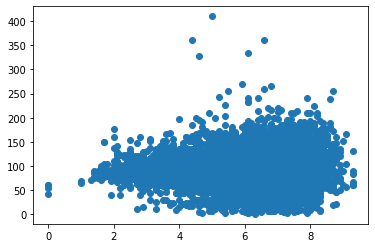

In [ ]:
plt.scatter(df['IMDb'], df['Runtime'])
plt.show()

### Рассчёт регрессии и проверка значимости

Рассчитыаем коэффициенты регрессии и изначения для для каждого из значений выборок. Результат расчёт показывает, что регрессия плохо описывает зависимость между данными и корее всего зависимости нет.

In [ ]:
ones = np.ones((16742,1))
x_pot = np.hstack((ones, df['IMDb'].values.reshape(16742,1)))

In [ ]:
XTX = x_pot.T.dot(x_pot)
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(x_pot.T).dot(df['Runtime'])
z = x_pot.dot(b)
e = df['Runtime'] - z

In [ ]:
R = 1 - sum_of_squares(e) / sum_of_squares(np.array(df['Runtime']))
R

0.008215797308753992

### Статистический тест

Построим статистический тест с нулевой гипотезой о том, что зависимости между рейтингом и длительностью нет.

Однако, мы увидим, что не смотря на малое  значение коэффициента детерминации эта зависимость всё же есть. Длинее фильмы - выше оценка.

In [ ]:
n = 16742
m = 1

k1 = m
k2 = n - m - 1

k1, k2

(1, 16740)

In [ ]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

3.84201438397215

In [ ]:
F = (R / k1) / ((1 - R) / k2)
F

138.6717459053512

Так как результат расчёта $F > t$, то зависимость есть.

### Визуализация зависимости 

Визуализирова зависимость мы и вправду видим некоторую связь между длинной и оценкой.

In [ ]:
b1 = np.cov(df['Runtime'], df['IMDb'], ddof=1)[0, 1] / np.var(df['Runtime'], ddof=1)
b0 = df['IMDb'].mean() - b1 * df['Runtime'].mean()

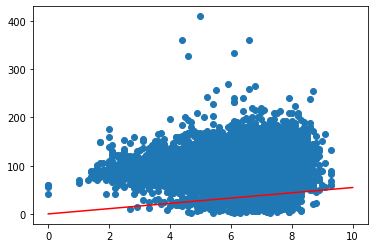

In [ ]:
plt.scatter(df['IMDb'], df['Runtime'])
x = np.linspace(0, 10, 1000)
y = b0*x + b1
plt.plot(x, y, color = 'r')
plt.show()

## Верно ли, что фильмы только на английском оценивают иначе, чем фильмы с другими языками?

Разделим нашу выборку на две части с фильмами только на английском языке и с фильмами с переводом  на другие языки.

Проведём дисперсионный анализ для средний значени оценок по выборке. Так как $F > t$, то можно точно сказать, что оценка действительно зависит от наличия переводов. Переведённые фильмы - лучше, чем те, что остались без перевода. А значит, всего треть фильмов за последнее время в голливуде достаточно интересны для того, чтобы их можно было смотреть за переделаи США. 

In [ ]:
def var_analise(df, df1, df2, f):
  all1 = df1.shape[0]
  all2 = df2.shape[0]
  res1_mean = df1[f].mean()
  res2_mean = df2[f].mean()
  res_mean = df[f].mean()
  SS_b = all1 * (res1_mean - res_mean) ** 2 + all2 * (res2_mean - res_mean) ** 2
  SS_w = ((df1[f] - res1_mean) ** 2).sum() + ((df2[f]- res2_mean) ** 2).sum()

  k = 2
  n = all1 + all2
  k1 = k - 1
  k2 = n - k
  sigma2_b = SS_b / k1
  sigma2_w = SS_w / k2
  sigma2_b, sigma2_w

  F = sigma2_b / sigma2_w

  alpha = 0.05

  t = stats.f.ppf(1 - alpha, k1, k2)

  return F>t

In [ ]:
df1 = df[df['Language'] == 'English']
df2 = df[df['Language'] != 'English']

In [ ]:
var_analise(df, df1, df2, 'IMDb')

True

In [ ]:
res1_mean = df1['IMDb'].mean()
res2_mean = df2['IMDb'].mean()

print(f'Only english: {res1_mean}, with translation {res2_mean}')

Only english: 5.735612561621278, with translation 6.238493434692411


## Верно ли, что фильмы только на английском оценивают иначе, чем фильмы с другими языками?

Так как  F>t , то можно точно сказать, что длительно действительно зависит от наличия переводов. Переводимые фильмы в среднем длинее.

In [ ]:
var_analise(df, df1, df2, 'Runtime')

True

In [ ]:
res1_mean = df1['Runtime'].mean()
res2_mean = df2['Runtime'].mean()

In [ ]:
print(f'Only english: {res1_mean}, with translation {res2_mean}')

Only english: 87.39821069928793, with translation 104.33863165169316


## А оценки фильмов, представленных на netflix и не представленных отличаются?

Да, статистически отличаются. 

```
# Выбран кодовый формат
```



In [ ]:
df1 = df[df['Netflix'] == 1]
df2 = df[df['Netflix'] != 1]

In [ ]:
var_analise(df, df1, df2, 'IMDb')

True

In [ ]:
res1_mean = df1['IMDb'].mean()
res2_mean = df2['IMDb'].mean()

In [ ]:
print(f'Netflix: {res1_mean}, not netflix {res2_mean}')

Netflix: 6.247893258426924, not netflix 5.818070095585029


## Влияют ли жанры на оценку?

Проведём анализ зависимости оценки от качественного фактора "жанр". Для этого разобъём нашу таблицу на дамми переменные по жанрам. Построим ради интереса матрицу корелляции. 

Затем проведём дисперсиоанный анализ для всех пар выборок и построим график разброса результата. Можно однозначно сказать, что в большинстве случае жанр влияет на оценку (красные точки), и в меньшестве случаев (синие точки) жанр статистически на оценку не влияет. 

In [ ]:
seperated_genres = df['Genres'].str.get_dummies(',')
dataset_with_genres = pd.concat([df, seperated_genres], axis = 1, sort = False)

In [ ]:
list_of_genres = seperated_genres.columns

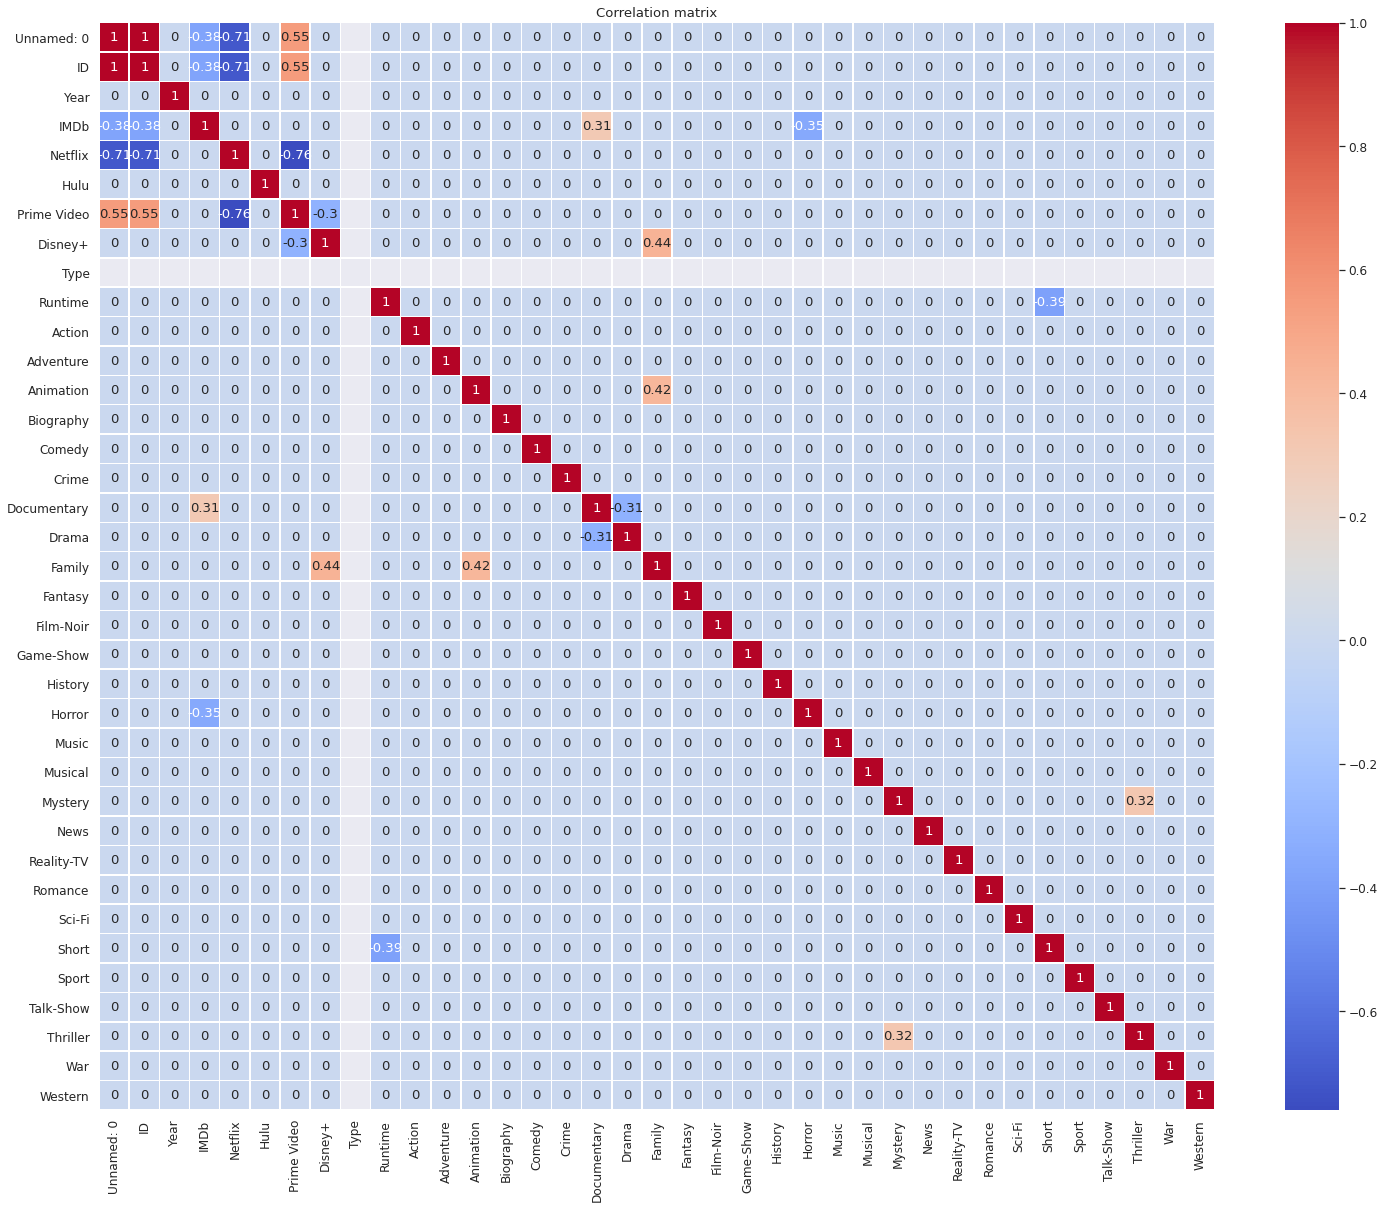

In [ ]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.1)

corr_matrix = dataset_with_genres.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Отсекаем маленьеи корелляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [ ]:
list_of_res = []
for i in combinations(list_of_genres, 2):
  #print(i)
  dict = {}
  dict['g1'] = i[0]
  dict['g2'] = i[1]
  wdf = dataset_with_genres[[i[0], i[1], 'IMDb']]
  wdf = wdf.loc[ (wdf[i[0]]==1) | (wdf[i[1]]==1) ]
  wdf1 = wdf[wdf[i[0]]==1]
  wdf2 = wdf[wdf[i[1]]==1]
  
  dict['va'] = var_analise(wdf, wdf1, wdf2, 'IMDb')
  dict['g1_mean'] = wdf1['IMDb'].mean()
  dict['g2_mean'] = wdf2['IMDb'].mean()
  list_of_res.append(dict)

In [ ]:
resframe3 = pd.DataFrame(list_of_res)
resframe3[resframe3['va'] == False]

,g1,g2,va,g1_mean,g2_mean
10,Action,Game-Show,False,5.455725,6.128571
17,Action,Reality-TV,False,5.455725,5.668182
22,Action,Talk-Show,False,5.455725,5.900000
33,Adventure,Fantasy,False,5.621497,5.691185
35,Adventure,Game-Show,False,5.621497,6.128571
...,...,...,...,...,...
337,Short,Talk-Show,False,6.402332,5.900000
341,Sport,Talk-Show,False,6.408416,5.900000
345,Talk-Show,Thriller,False,5.900000,5.360763
346,Talk-Show,War,False,5.900000,6.246753


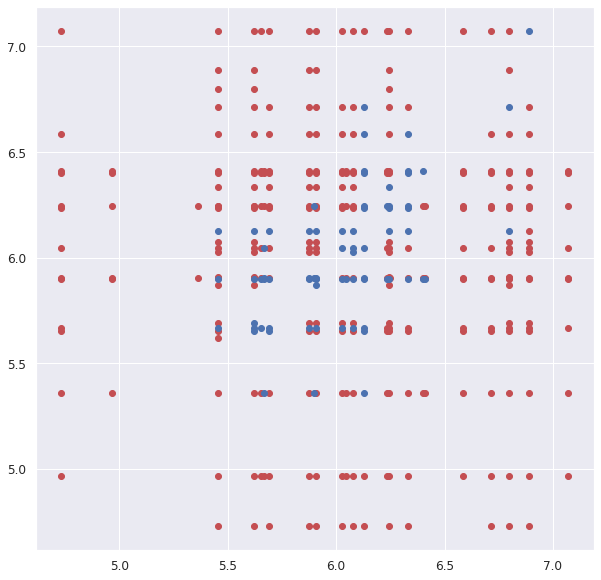

In [ ]:
plt.figure(figsize = (10,10))

plt.scatter(resframe3.loc[resframe3['va'] == True, 'g1_mean'], resframe3.loc[resframe3['va'] == True, 'g2_mean'], color = 'r')
plt.scatter(resframe3.loc[resframe3['va'] == False, 'g1_mean'], resframe3.loc[resframe3['va'] == False, 'g2_mean'], color = 'b')

# Выводы

Как бы нам не хотелось обратного, подвоха внутри нет. Рейтинг на IMDb распределён нормально, как и длительность фильмов. Это позволяет провести дисперсионный анализ различных закономерностей и выявить, что в США много плохих фильмов, которые даже не переводят на другие языки.

Эти фильмы статистически значимо оценивают хуже, чем тем, что переводятся на иные языки. То есть не всё, что делают в знаменитом Голливдуе идёт на экспорт, хотя нам так казалось. 

Интересно и то, что фильмы разных жанров в 80% случаев имеют разные оценки. Высокая оценка для хорора будет отличаться от высокой оценки для экшена. 

Ну и фильмы на netflix - действительно лучше общей массы. Элитная площадка. 

